In [ ]:
!pip install pytorch-lightning
!pip install transformers
!pip install sentencepiece
!pip install datasets
!pip install ml_things
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from ml_things import plot_dict, plot_confusion_matrix, fix_text
import pandas as pd
import numpy as np

In [3]:
num_labels = 2
model_type = 'allenai/longformer-base-4096'

In [4]:
def read_from_file(filename):
    file = open(filename,"r")
    vocab = file.read().splitlines()
    return vocab

In [19]:
data_path = "/content/drive/MyDrive/Spark/PIT_UN/pit_longformer_data.csv"
data = pd.read_csv(data_path)
data = data[data['Pre-processed text 2'].notna()]
data.head()

,University,Course,Link,Status,Text,Notes,Pre-processed text 1,Pre-processed text 2,Pre-processed text 3,pit
0,Arizona State University,Principles of Public Interest Technology,https://webapp4.asu.edu/bookstore/viewsyllabus...,Not Found,PIT 501: Principles of Public Interest Techno...,NaN,PIT 501: Principles of Public Interest Technol...,PIT 501: Principles of Public Interest Technol...,"['pit', 'principle', 'public', 'interest', 'te...",1.0
1,Boston University,XCC433: Justice Media co-Lab,https://www.bu.edu/cds-faculty/files/2021/04/C...,Found,THE JUSTICE MEDIA CO-LAB Journalism is strong...,NaN,THE JUSTICE MEDIA CO-LAB Journalism is stronge...,THE JUSTICE MEDIA CO-LAB Journalism is stronge...,"['justice', 'medium', 'colab', 'journalism', '...",1.0
2,Boston University,Law & Algorithms,https://cs-people.bu.edu/kaptchuk/teaching/ds4...,Found,Page 1 of 8 Law and Algorithms – Spring 2022 ...,NaN,Page 1 of 8 Law and Algorithms – Spring 2022 S...,Page 1 of 8 Law and Algorithms – Spring 2022 S...,"['page', 'law', 'algorithm', 'spring', 'syllab...",1.0
3,Cal Poly State,The art of ethical design,NaN,Found,View Static Version Course Principles. Student...,No difference between processed text 1 and 2,View Static Version Course Principles. Student...,View Static Version Course Principles. Student...,"['view', 'static', 'version', 'course', 'princ...",1.0
4,Cal Poly State,Humanity for Sale: Ethics in Business and Tech...,https://static1.squarespace.com/static/5e6488a...,Found,Humanity for sale Ethics in Business and Tech...,No difference between processed text 1 and 2,Humanity for sale Ethics in Business and Techn...,Humanity for sale Ethics in Business and Techn...,"['humanity', 'sale', 'ethic', 'business', 'tec...",1.0


In [20]:
X = list(data["Pre-processed text 2"])
y = list(data["pit"])
y = [int(i) for i in y]

In [21]:
for i, x in enumerate(X):
  if type(x) != str:
    print(i)

In [22]:
len(X)

107

In [23]:
from transformers import LongformerTokenizer
checkpoint = model_type
tokenizer = LongformerTokenizer.from_pretrained(checkpoint, do_lower_case=True)

In [24]:
max_len = 0
cnt = 0

# For every sentence...
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    #print(sent1,sent2)
    #print(input_ids)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    if len(input_ids) > 4096:
      cnt += 1

print('Max sentence length: ', max_len)
print(cnt)

Token indices sequence length is longer than the specified maximum sequence length for this model (4157 > 4096). Running this sequence through the model will result in indexing errors


Max sentence length:  7771
26


In [25]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


In [26]:
import torch
def process_trainingdata(tokenizer, training_set, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  token_type_ids=[]

  # For every sentence...
  for sent in training_set:
    encoded_dict = tokenizer(
                        sent,                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 4096,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', training_set[0])
  print('Token IDs:', input_ids[0])
  return input_ids,attention_masks,labels

In [27]:
input_ids, attention_masks, labels = process_trainingdata(tokenizer, X, y)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  PIT 501: Principles of Public Interest Technology Professor: Zoom office: https://asu.zoom.us/j/7712166804 Office hours: 3-4 Tuesdays and as needed. Please email me to schedule Zoom office appointments. Course Description This course introduces students to the fundamentals of public interest technology (PIT), including key concepts, theories and frameworks. Students will identify and analyze stakeholders, societal dimensions, and policy issues in the context of current and emerging technologies such as facial recognition technology, biotechnology, artificial intelligence and financial technology. Students will be introduced to the importance of socio-technical change, public values, anticipatory governance,1 of 8 **Disclaimer** This syllabus is to be used as a guideline only. The information provided is a summary of topics to be covered in the class. Information contained in this document such as assignments, grading scales, due dates, office hours, required books and materi

In [28]:
input_ids[0]

tensor([   0,  510, 2068,  ...,    1,    1,    1])

In [29]:
from torch.utils.data import TensorDataset, random_split

def datasetsize(input_ids, attention_masks, labels):
  dataset = TensorDataset(input_ids, attention_masks, labels)

  train_size = int(0.7 * len(dataset))
  val_size = len(dataset) - train_size

  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  print('{:>5,} training samples'.format(train_size))
  print('{:>5,} validation samples'.format(val_size)) 
  return train_dataset,val_dataset

In [30]:
train_dataset_longformer, val_dataset_longformer = datasetsize(input_ids, attention_masks, labels)

   74 training samples
   33 validation samples


In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
def dataloader(size,train_dataset,val_dataset):
  batch_size = size
 
  train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
  validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
  return train_dataloader, validation_dataloader

In [32]:
train_dataloader_longformer, validation_dataloader_longformer = dataloader(2, train_dataset_longformer, val_dataset_longformer)

In [33]:
from transformers import AutoConfig, LongformerForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_longformer = LongformerForSequenceClassification.from_pretrained(
    model_type, 
    num_labels = num_labels,   
    output_attentions = False,
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model_longformer.cuda()

Downloading:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weig

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

In [34]:
def optimizer(model):
  opt = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  return opt

In [35]:
optimizer_longformer = optimizer(model_longformer)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [36]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
def scheduler(train_dataloader,optimizer):
  epochs = 10

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  sch = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps) 
  return sch

In [37]:
scheduler_longformer = scheduler(train_dataloader_longformer,optimizer_longformer)

In [38]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [39]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [40]:
def save(model, path):
    # save
    torch.save(model.state_dict(), path)

In [41]:
import random
import numpy as np

def modeltraining(model,train_dataloader,validation_dataloader,opt,sch):

  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  total_t0 = time.time()
  epochs = 10
  all_loss = {'train_loss':[], 'val_loss':[]}
  all_acc = {'train_acc':[], 'val_acc':[]}

  for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_accuracy += flat_accuracy(logits.detach().cpu().numpy(), b_labels.to('cpu').numpy())

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        opt.step()

        sch.step()

        if step % 20 == 0 and not step == 0:

          save(model, '/content/drive/MyDrive/Spark/PIT_UN/longformer_preprocess2.cpkt')

    avg_train_acc = total_train_accuracy / len(train_dataloader) 
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)
    

    print("")
    print("  Average training Accuracy: {0:.2f}".format(avg_train_acc))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for step, batch in enumerate(validation_dataloader):        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)

    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Accu.': avg_train_acc,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    all_loss['train_loss'].append(avg_train_loss)
    all_loss['val_loss'].append(avg_val_loss)
    all_acc['train_acc'].append(avg_train_acc)
    all_acc['val_acc'].append(avg_val_accuracy)

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

  # Plot accuracy curves.
  plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
  return model, training_stats, all_loss, all_acc


======== Epoch 1 / 10 ========
Training...
  Batch    20  of     37.    Elapsed: 0:00:20.

  Average training Accuracy: 0.61
  Average training loss: 0.62
  Training epcoh took: 0:00:36

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.66
  Validation took: 0:00:04

======== Epoch 2 / 10 ========
Training...
  Batch    20  of     37.    Elapsed: 0:00:17.

  Average training Accuracy: 0.85
  Average training loss: 0.45
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.76
  Validation Loss: 1.03
  Validation took: 0:00:04

======== Epoch 3 / 10 ========
Training...
  Batch    20  of     37.    Elapsed: 0:00:17.

  Average training Accuracy: 0.88
  Average training loss: 0.43
  Training epcoh took: 0:00:34

Running Validation...
  Accuracy: 0.79
  Validation Loss: 1.13
  Validation took: 0:00:04

======== Epoch 4 / 10 ========
Training...
  Batch    20  of     37.    Elapsed: 0:00:17.

  Average training Accuracy: 0.93
  Average training loss: 0.23
  Training

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


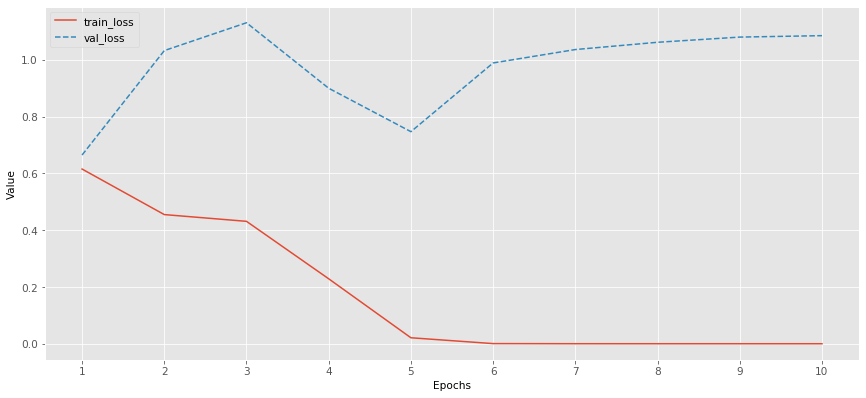

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


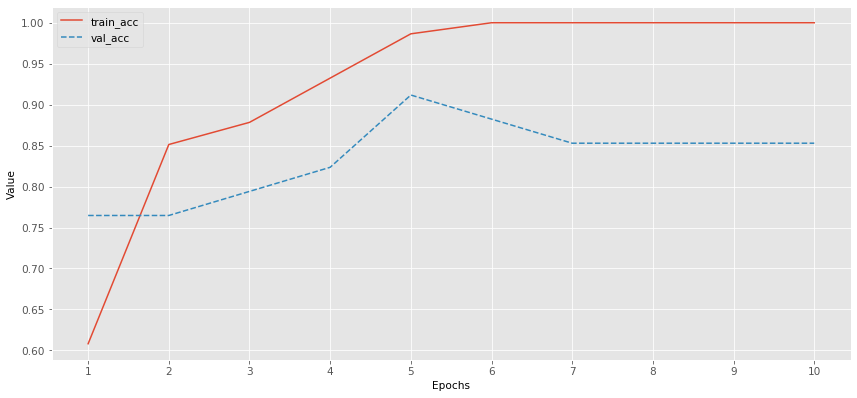

In [42]:
model, training_stats, all_loss, all_acc = modeltraining(model_longformer,train_dataloader_longformer,validation_dataloader_longformer,optimizer_longformer,scheduler_longformer)

In [43]:
from transformers import AutoConfig, LongformerForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_test = LongformerForSequenceClassification.from_pretrained(
    model_type, 
    num_labels = num_labels,   
    output_attentions = False,
    output_hidden_states = False,
)

# Tell pytorch to run this model on the GPU.
model_test.cuda()

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weig

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

In [44]:
model_test.load_state_dict(torch.load('/content/drive/MyDrive/Spark/PIT_UN/longformer_preprocess2.cpkt'))

<All keys matched successfully>

In [45]:
def predicttestset(model, b_input_ids, b_input_mask):
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []
  total_eval_accuracy = 0
  total_eval_loss = 0

  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions.
    result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask,
                    return_dict=True)

  # loss = result.loss
  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)
  return predictions

In [46]:
x_non_pit = "GEORGETOWN UNIVERSITY DEPARTMENT OF PSYCHOLOGY General Psychology Course Syllabus, Summer 2015 Section PSYC-001-10  office: White-Gravenor 306-I Classes: Mondays–Thursdays 1:00P.M.–3:00P.M., Room 202 White-Gravenor. Classes will consist of lecture with periods allotted for discussion. Most classes will involve demonstrations, illustrations, or videos as well. Office Hours: After every class, 3:00–4:00 P.M., in White-Gravenor 306-I These hours provide an opportunity for questions and discussion in a more informal atmosphere. Texts: Two books, both available in the University Bookstore (and elsewhere).  Exploring Psychology in Modules, 9 th ed., by David G. Myers. NOTE: There are many versions of this text and you must avoid getting the wrong one! First, get the 9th edition—it’s much more up-to-date. Second, get EXPLORING Psychology, not plain Psychology—it’s briefer. Third, get Exploring Psychology IN MODULES—it’s divided into 43 mini-chapters rather than 15 megachapters. (Worth Publishers, 2014: paperback, ISBN: 978-1-4641-1173-0) (Note: the loose-leaf version is perfectly fine, ISBN: 978-1-4641-0927-0)  The Norton Psychology Reader, edited by Gary Marcus. (paperback, Norton, 2006). Description: This introductory course surveys the field of academic psychology and acquaints students with its major approaches and topics. This course counts toward the Social Science component of the College’s General Education requirement, is prerequisite for all other courses offered by the Psychology Department, and is required for a major in Psychology. Learning Goals: The learning goals of the undergraduate psychology program at Georgetown University may be found at: http://psychology.georgetown.edu/undergraduate/learninggoals/. This course is intended particularly to address the objectives listed under Goal 1: Foundational Knowledge. The course also addresses aspects of Goal 3: Application of Psychology (particularly objectives a and b) and Goal 4: Values in Psychology (particularly objectives a, b, and c). Web Site: This cl"

In [47]:
encoded_dict = tokenizer(
                        x_non_pit,                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 4096,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [48]:
encoded_dict['input_ids']

tensor([[   0, 8800, 3411,  ...,    1,    1,    1]])

In [49]:
input_ids = [encoded_dict['input_ids']]
    
# And its attention mask (simply differentiates padding from non-padding).
attention_masks = [encoded_dict['attention_mask']]

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0).to(device)
attention_masks = torch.cat(attention_masks, dim=0).to(device)

In [50]:
prediction = predicttestset(model, input_ids, attention_masks)

In [51]:
prediction

[array([[ 1.3159486, -1.0668576]], dtype=float32)]

In [52]:
x_pit = "Spring 2022_Human-AI Interaction Syllabus Human-AI Interaction Course number: INF 385T (Unique ID: 28260) Time: 3pm-6pm CT Mondays Synchronous Online Meeting: zoom link will distributed through canvas Office hours: Scheduled upon request Instructor: (Pronouns: she/her),Teaching assistant: Roza Atarod (Pronouns: she/her), atarod@utexas.edu Course Description Advances in artificial intelligence (AI) have changed the way decisions are made in organizations, governments, and everyday life. This course will provide an introduction to combining human and machine intelligence to benefit people and society. Students will learn cutting-edge research on a number of topics related to human-AI interaction, including the psychological and societal impacts of AI, AI biases and fairness, transparency and explainability, human-in-the-loop decision-making/human-AI collaboration, robots and natural language based AI, and design guidelines and methods for AI user experiences. These topics will be explored in the context of real-world applications, including online social media and labor platforms, algorithmic management tools for worker hiring and evaluation, and decision-support tools for public administrative decisions on risk assessment and resource distribution. Students will form interdisciplinary teams and learn through projects how to critically analyze existing AI systems, study their human impact, and design new systems to be human-centered. Note: This course is about human-centric theories and methods for envisioning AI systems. It will provide no technical insight on machine learning, data-mining, or statistical pattern recognition. Prior experience with social science research, programming, AI/machine learning, human-computer interaction or interaction design, or user research will be helpful. This class is interdisciplinary and you will be able to craft a project that best fits your background. Learning Outcomes You will learn principles and methods for designing human-centered AI ● Be aware of open challenges in the field ● Understand cutting-edge principles and methods that address the challenges ● Know how to adopt and advance the human-centered AI principles and methods ● Practice reflecting critically on the use of AI in society, identifying problems, and having a constructive stance Prerequisite for the Course There is no prerequisite for this course. This is a graduate-level, special topic course. In this class, you will not learn basic skills and methods in social science research, human-centered design, or data science/AI/machine learning. You will be expected to combine skills & methods Spring 2022_Human-AI Interaction Syllabus 2 that you already know with HAI principles and methods you will learn in the class in order to conduct your project. How Will You Learn? Statement of Learning Success Your success in this class is important to me. We all learn differently, and everyone struggles sometimes. You are not, ever, the only one having difficulty. If there are aspects of this course that prevent you from learning or exclude you, please let me know as soon as possible. Together we will develop strategies to meet both your needs and the requirements of the course. I also encourage you to reach out to the student resources available through UT and I am happy to connect you with a person or Center if you would like. If immediate mental health assistance is needed, call the Counseling and Mental Health Center (CMHC) at 512-471-3515 or you may also contact Bryce Moffett, LCSW (iSchool CARE counselor) at 512-232-2983. Outside CMHC business hours (8a.m.-5p.m., Monday-Friday), contact the CMHC 24/7 Crisis Line at 512-471-2255. Teaching Modality Information The class will be done through synchronous online meetings. The main learning in this class happens through active discussion and in-class activities as well as projects. Thus, it is critical to attend the class 2-3 pm CT Mondays. The course will not be recorded. There will be no alternative to synchronous zoom attendance other than normal emergency accommodations. Communication The course Canvas site can be found at utexas.instructure.com and Slack. Please email me through Slack or Canvas. You are responsible for ensuring that the primary email address you have recorded with the university is the one you will check for course communications because that is the email address that Canvas and Slack use. Asking for Help You can ask questions to me or Roza and arrange individual meetings with us via Slack or Canvas. Diversity, Equity, and Inclusion It is my intent that students from all diverse backgrounds and perspectives be well served by this course, that students’ learning needs be addressed, and that the diversity that students bring to this class can be comfortably expressed and be viewed as a resource, strength and benefit to all students. Please come to me at any time with any concerns. Services for Students with Disabilities The university is committed to creating an accessible and inclusive learning environment consistent with university policy and federal and state law. Please let me know if you experience any barriers to learning so I can work with you to ensure you have equal opportunity to participate fully in this course. If you are a student with a disability, or think you may have a Spring 2022_Human-AI Interaction Syllabus 3 disability, and need accommodations please contact Services for Students with Disabilities (SSD). Please refer to SSD’s website for contact and more information: http://diversity.utexas.edu/disability/. If you are already registered with SSD, please deliver your Accommodation Letter to me as early as possible in the semester so we can discuss your approved accommodations and needs in this course. Course Requirements and Grading ● Required Materials: All course readings will be available via the course Canvas site. ● Required Devices: You need access to computers to download the readings and complete the assignments. ● Classroom expectations: Please make sure to be engaged and respectful, and to contribute to discussions. Assignments 1. Attendance & active participation. Students are expected to attend every class. Every student should demonstrate ongoing engagement in class discussions. Absences will only be excused in situations following university policy (illness, religious holy days, participation in University activities at the request of university authorities, and compelling absences beyond your control) with proper documentation and timely notification (prior to class for non-emergencies). 2. In-class activities. Some weeks will involve in-class activities. n-class activities include discussion activities prepared by reading panels as well as worksheet activities prepared by the instructor and the TA. Once students complete the activities, the results will be reviewed by a set of other students or shared with the entire class. The completion and review of the activities will be completed during the class time. 3. Reading reflections. You will be assigned 2-3 readings per week. The readings are carefully chosen to provide knowledge of both foundational work in the field and up-to-date, cutting edge trends, methods, and studies. The weekly lectures will not cover the content of the readings, so it is very important that you take the time to read these materials and reflect on them. As you read the materials, note down your thoughts and questions. Discussion questions can cover a range of topics, including useful take-aways and implications in terms of the methods and findings of the paper, observations about trends in the field, doubts or concerns about the findings and/or trends, next steps for researchers and practitioners, and how to apply take-aways and implications in the real world. Reading reflection question submission. Before 6 pm CT on Thursdays, you will submit three discussion questions about the assigned readings via the provided website. You will then read all the questions submitted by your classmates and vote for the questions that you’d like to discuss in the class by 2 CT pm on Fridays. The reading panel teams will include the questions with the most votes in the class discussion. The TA will keep track of questions that you submit Spring 2022_Human-AI Interaction Syllabus 4 each week. Submitting three thoughtful discussion questions for all weeks will result in a full score on the reading reflection assignment. 4. Reading quizzes. For the weeks with assigned readings, there will be brief, 5-10 minute long, open-book quizzes that ask basic knowledge and take-aways from the required readings. The quizzes will be easy. The quizzes are not meant to test your memorization ability; they are designed to ensure that you understand and can quickly retrieve foundational concepts from the readings. (Most questions will require verbatim answers taken from the readings.) The number of questions and allotted times will vary depending on the week’s readings, but it will not exceed 10 minutes. The quiz will take place as the first activity of the class (e.g., 3:01 pm - 3:06 pm/3:11 pm CT). Late submissions, in other words, quizzes that are submitted after 3:06 pm/3:11 pm CT, will not be considered, so please make sure that you join the class on time so that you can submit the answers on time. 5. In-class reading panel activity. You will be part of the reading panel once in the semester. The panel will consist of two to three students, and will lead an in-class reading discussion for about one hour. Presentation (10 minutes): Reading summary (5 minutes): You will prepare 3-5 slides to summarize the papers. Please note 2-3 key concepts, findings, and/or take-aways that you want to ensure that your classmates remember. Discussion and group activities (5 minutes): Then, you will pose three themes that cover all the required readings for discussion and group activities. The panel should synthesize questions raised by classmates and draw out three themes. In your presentation, for each of the three themes, present the overarching theme and then list the questions submitted by your classmates on which the theme is based. The top-voted reading reflection questions may indicate topics that most students are interested in. Based on the themes, you will prepare google slides or google docs that can structure each student group’s discussion and activities; each group will use a google slide/doc to document their outcomes. The instructor will also provide examples from the last semester for the panel’s inspiration and provide feedback on the activities so please get in touch with the instructor early. Prepare your own thoughts in response to these questions to set the stage for discussion. Discussion (35 minutes): After the panelists’ presentation, we will randomly divide the class into small groups (2-3 students in each) to discuss the topics following the panel’s instruction. Each group (not individual students) should make a copy of the panel’s google slides/doc, and use it to organize their discussion and write down their outcomes. Discussion activity peer-review (10 minutes): After the discussion, each group’s discussion outcome report will be randomly assigned to different students. Students will follow a rubric to Spring 2022_Human-AI Interaction Syllabus 5 evaluate the outcome report. All students will also provide reviews of the panel’s discussion activity guideline itself. 6. Term Project. You will work on a term project. Detailed guidelines are documented in the Project Guidelines document. 7. Teamwork peer evaluation. We will conduct two teamwork peer evaluation surveys, one during the midterm period and the other at the final. In the survey, you will be asked to evaluate your teammates, including yourself, and your collaboration experiences. The survey results will be factored into the overall teamwork peer evaluation grade. Assignments Percent of Total Grade / Points Possible 1. Attendance & active participation 10% 2. In-class activities 10% 3. Reading reflections 10% 4. Reading quizzes 5% 5. In-class reading panel activity 10% 6. Project 50% 7. Overall teamwork peer evaluation 5% Late Work and Extensions We will use a limited extension method on our assignment deadlines (i.e., reading reflections and projects), which we call Extra hours. This is to provide you with some flexibility for the times of heavy workload, minor illness, job interviews, conference travels, and other exceptional, yet often predictable circumstances. You will have a total of 120 Extra hours for the entire semester, and you may apply Extra hours to any reading reflection and project assignments. The Extra hours will be deducted in one hour increments. This means that, if you upload your assignment 122 minutes late, it will use up 3 Extra hours. You can use at most 36 slack hours (1.5 days) for a given assignment. Assignments more than 36 hours late will not be accepted. If a team assignment is using Extra hours, every member’s hour will be deducted. Extra hours cannot be applied to midterm and final presentations, and in-class reading panel activities. Extra hours are not to support procrastination. Late submissions should only occur in exceptional circumstances. If you use up your Extra hours and seek further extensions, you will first need to provide acceptable justifications for all Extra hours that you used. Spring 2022_Human-AI Interaction Syllabus 6 Absences Absences will result in the reduction of the attendance and active participation grade. Absences will only be excused in situations following university policy (illness, religious holy days, participation in University activities at the request of university authorities, and compelling absences beyond your control) with proper documentation and timely notification (prior to class for non-emergencies). Equitable Accommodation and Extra Credit The semester-long project is a pivotal element of your learning experience. Each project will involve a series of milestones that you will build off for the next milestone. If you improve your submission based on our feedback, we will update the grade assigned to the milestone. We encourage iteration, which is a foundation of any great work! +/- Grading Policy and Grade Breaks +/- grades will be used for the final class grade. A 94-100% A- 90-93% B+ 87-89% B 84-86% B- 80-83% C+ 77-79% C 74-76% For detailed information about what grade is required for you to receive credit for this class, please refer to UT’s Graduate Catalog. For example, students in the School of Information are required to receive a grade of B or higher in order to include this course in their program of work toward graduation. In addition, the UT Graduate School requires a minimum grade of C or higher to count a course for credit. Course Outline The detailed, up to date course outline is here and also posted on canvas. Changes to the schedule may be made at my discretion if circumstances require. I will announce any such changes in class and will also communicate them via a Canvas announcement and Slack. It is your responsibility to note these changes when announced, and I will do my best to ensure that you are notified of changes with as much advance notice as possible. Week Date Topic Week 1 1/24 Introduction Week 2 1/31 Human experiences with AI in platforms, workplaces, and cities Week 3 2/7 Designing AI user experiences Week 4 2/14 Transparent and explainable AI Week 5 2/21 Fair and responsible AI Spring 2022_Human-AI Interaction Syllabus 7 Week 6 2/28 Designing AI with stakeholders Week 7 3/7 Human-in-the-loop systems and human-AI collaboration Week 8 3/14 Spring break Week 9 3/21 Designing for failure Week 10 3/28 Data ethics and transparency Week 11 4/4 Embodied AI: Robots and self-driving cars Week 12 4/11 NLP-based AI: Chatbots and voice agents Week 13 4/18 Work session Week 14 4/25 Work session Week 15 5/2 Final Presentations Course Policies and Disclosures 8 Academic Integrity Expectations 8 Confidentiality of Class Recordings 8 Getting Help with Technology 8 Content Warning 8 Sharing of Course Materials is Prohibited 8 Religious Holy Days 9 Names and Pronouns 9 Land Acknowledgment 9 University Resources for Students 9 Services for Students with Disabilities (SSD) 9 Counseling and Mental Health Center (CMHC) 10 University Health Services (UHS) 10 Sanger Learning Center 10 Students Emergency Services (SES) 10 Important Safety Information 10 Classroom Safety and COVID-19 11 Carrying of Handguns on Campus 11 Spring 2022_Human-AI Interaction Syllabus 8 Title IX Disclosure 12 Campus Safety 12 Course Policies and Disclosures Academic Integrity Expectations Students who violate University rules on academic dishonesty are subject to disciplinary penalties, including the possibility of failure in the course and/or dismissal from the University. Since such dishonesty harms the individual, all students, and the integrity of the University, policies on academic dishonesty will be strictly enforced. For further information, please visit the Student Conduct and Academic Integrity website at: http://deanofstudents.utexas.edu/conduct. [Also, for the types of assignments in your syllabus, include individual policies relating to collaboration and plagiarism. Student Conduct and Academic integrity in the Office of the Dean of Students reports that students often claim they were unaware of academic integrity expectations because they were not outlined in the syllabus.] Confidentiality of Class Recordings Class recordings are reserved only for students in this class for educational purposes and are protected under FERPA. The recordings should not be shared outside the class in any form. Violation of this restriction by a student could lead to Student Misconduct proceedings. Getting Help with Technology Students needing help with technology in this course should contact the ITS Service Desk or the instructor/TA. Content Warning Our classroom provides an open space for the critical and civil exchange of ideas. Some readings and other content in this course may include topics that some students may find offensive and/or traumatizing. I’ll aim to forewarn students about potentially disturbing content and I ask all students to help to create an atmosphere of mutual respect and sensitivity. Sharing of Course Materials is Prohibited No materials used in this class, including, but not limited to, lecture hand-outs, videos, assessments (quizzes, exams, papers, projects, homework assignments), in-class materials, review sheets, and additional problem sets, may be shared online or with anyone outside of the class without explicit, written permission of the instructor. Unauthorized sharing of materials promotes cheating. The University is well aware of the sites used for sharing materials, and any materials found online that are associated with you, or any suspected unauthorized sharing of materials, will be reported to Student Conduct and Academic Integrity in the Office of the Dean of Students. These reports can result in sanctions, including failure of the course. Spring 2022_Human-AI Interaction Syllabus 9 Religious Holy Days By UT Austin policy, you must notify me of your pending absence as far in advance as possible of the date of observance of a religious holy day. If you must miss a class, an examination, a work assignment, or a project in order to observe a religious holy day, you will be given an opportunity to complete the missed work within a reasonable time after the absence. Names and Pronouns Professional courtesy and sensitivity are especially important with respect to individuals and topics dealing with differences of race, culture, religion, politics, sexual orientation, gender, gender variance, and nationalities. I will gladly honor your request to address you by your chosen name and by the gender pronouns you use. Class rosters are provided to the instructor with the student’s chosen (not legal) name, if you have provided one. If you wish to provide or update a chosen name, that can be done easily at this page, and you can add your pronouns to Canvas. Land Acknowledgment I would like to acknowledge that we are meeting on the Indigenous lands of Turtle Island, the ancestral name for what now is called North America. Moreover, I would like to acknowledge the Alabama-Coushatta, Caddo, Carrizo/Comecrudo, Coahuiltecan, Comanche, Kickapoo, Lipan Apache, Tonkawa and Ysleta Del Sur Pueblo, and all the American Indian and Indigenous Peoples and communities who have been or have become a part of these lands and territories in Texas. University Resources for Students Services for Students with Disabilities (SSD) The university is committed to creating an accessible and inclusive learning environment consistent with university policy and federal and state law. Please let me know if you experience any barriers to learning so I can work with you to ensure you have equal opportunity to participate fully in this course. If you are a student with a disability, or think you may have a disability, and need accommodations please contact Services for Students with Disabilities (SSD). Please refer to SSD’s website for contact and more information: http://diversity.utexas.edu/disability/. If you are already registered with SSD, please deliver your Accommodation Letter to me as early as possible in the semester so we can discuss your approved accommodations and needs in this course. Counseling and Mental Health Center (CMHC) All of us benefit from support during times of struggle. Know you are not alone. If you or anyone you know is experiencing symptoms of stress, anxiety, depression, academic concerns, loneliness, difficulty sleeping, or any other concern impacting your wellbeing – you are strongly encouraged to connect with CMHC. The Counseling and Mental Health Center provides a wide Spring 2022_Human-AI Interaction Syllabus 10 variety of mental health services to all UT students including crisis services, counseling services with immediate support and well-being resources. Additionally, CARE Counselors are located within the academic schools and colleges. These counselors get to know the concerns that are unique to their college’s students. For more information on CMHC, visit https://cmhc.utexas.edu or call 512-471-3515. University Health Services (UHS) Your physical health and wellness are a priority. University Health Services is an on-campus high-quality medical facility providing care to all UT students. Services offered by UHS include general medicine, urgent care, a 24/7 nurse advice line, women’s health, sports medicine, physical therapy, lab and radiology services, COVID-19 testing and vaccinations and much more. For additional information, visit https://healthyhorns.utexas.edu or call 512-471-4955. Sanger Learning Center Did you know that more than one-third of UT undergraduate students use the Sanger Learning Center each year to improve their academic performance? All students are welcome to take advantage of Sanger Center’s classes and workshops, private learning specialist appointments, peer academic coaching, and tutoring for more than 70 courses in 15 different subject areas. For more information, please visit https://ugs.utexas.edu/slc or call 512-471-3614 (JES A332). Students Emergency Services (SES) Student Emergency Services in the Office of the Dean of Students helps students and their families during difficult or emergency situations. Assistance includes outreach, advocacy, intervention, support, and referrals to relevant campus and community resources. If you need to be absent from class due to a family emergency, medical or mental health concern, or academic difficulty due to crisis or an emergency situation, you can work with Student Emergency Services. SES will document your situation and notify your professors. Additional information is available at https://deanofstudents.utexas.edu/emergency/ or by calling 512-471-5017. Important Safety Information If you have concerns about the safety or behavior of fellow students, TAs or professors, contact BCCAL (the Behavior Concerns and COVID-19 Advice Line) at https://safety.utexas.edu/behavior-concerns-advice-line or by calling 512-232-5050. Confidentiality will be maintained as much as possible, however the university may be required to release some information to appropriate parties. Classroom Safety and COVID-19 To help preserve our in-person learning environment, the university recommends the following. ● Adhere to university mask guidance. Masks are strongly recommended, but optional, inside university buildings for vaccinated and unvaccinated individuals, except when alone in a private office or single-occupant cubicle. Spring 2022_Human-AI Interaction Syllabus 11 ● Vaccinations are widely available, free and not billed to health insurance. The vaccine will help protect against the transmission of the virus to others and reduce serious symptoms in those who are vaccinated. ● Proactive Community Testing remains an important part of the university’s efforts to protect our community. Tests are fast and free. ● We encourage the use of the Protect Texas App each day prior to coming to campus. ● If you develop COVID-19 symptoms or feel sick, stay home and contact the University Health Services’ Nurse Advice Line at 512-475-6877. If you need to be absent from class, contact Student Emergency Services and they will notify your professors. In addition, to help understand what to do if you have been had close contact with someone who tested positive for COVID-19, see this University Health Services link. ● Behavior Concerns and COVID-19 Advice Line (BCCAL) remains available as the primary tool to address questions or concerns from the university community about COVID-19. ● Students who test positive should contact BCCAL or self-report (if tested off campus) to University Health Services. ● Visit Protect Texas Together for more information. Carrying of Handguns on Campus Texas’ Open Carry law expressly prohibits a licensed to carry (LTC) holder from carrying a handgun openly on the campus of an institution of higher education such as UT Austin. Students in this class should be aware of the following university policies: ● Students in this class who hold a license to carry are asked to review the university policy regarding campus carry. ● Individuals who hold a license to carry are eligible to carry a concealed handgun on campus, including in most outdoor areas, buildings and spaces that are accessible to the public, and in classrooms. ● It is the responsibility of concealed-carry license holders to carry their handguns on or about their person at all times while on campus. Open carry is NOT permitted, meaning that a license holder may not carry a partially or wholly visible handgun on campus premises or on any university driveway, street, sidewalk or walkway, parking lot, parking garage, or other parking area. ● Per my right, I prohibit carrying handguns in my personal office. Note that this information will also be conveyed to all students verbally during the first week of class. This written notice is intended to reinforce the verbal notification, and is not a “legally effective” means of notification in its own right. Title IX Disclosure Beginning January 1, 2020, TexasSenate Bill 212 requires all employees of Texas universities, including faculty, to report any information to theTitle IX Office regarding sexual harassment, sexual assault, dating violence and stalking that is disclosed to them. Texas law requires that all employees who witness or receive any information of this type (including, but not limited to, writing assignments, class discussions, or one-on-one conversations) must be report it. If you Spring 2022_Human-AI Interaction Syllabus 12 would like to speak with someone who can provide support or remedies without making an official report to the university, please email advocate@austin.utexas.edu. For more information about reporting options and resources, visit http://www.titleix.utexas.edu/, contact the Title IX Office via email at titleix@austin.utexas.edu, or call 512-471-0419. Although graduate teaching and research assistants are not subject to Texas Senate Bill 212, they are still mandatory reporters under Federal Title IX laws and are required to report a wide range of behaviors we refer to as sexual misconduct, including the types of sexual misconduct covered under Texas Senate Bill 212.The Title IX office has developed supportive ways to respond to a survivor and compiled campus resources to support survivors. Faculty members and certain staff members are considered “Responsible Employees” or “Mandatory Reporters,” which means that they are required to report violations of Title IX to the Title IX Coordinator. I am a Responsible Employee and must report any Title IX-related incidents that are disclosed in writing, discussion, or one-on-one. Before talking with me or with any faculty or staff member about a Title IX-related incident, be sure to ask whether they are a responsible employee. If you want to speak with someone for support or remedies without making an official report to the university, email advocate@austin.utexas.edu For more information about reporting options and resources, visit the Title IX Office or email titleix@austin.utexas.edu. Campus Safety The following are recommendations regarding emergency evacuation from the Office of Campus Safety and Security, 512-471-5767, ● Students should sign up for Campus Emergency Text Alerts at the page linked above. ● Occupants of buildings on The University of Texas at Austin campus must evacuate buildings when a fire alarm is activated. Alarm activation or announcement requires exiting and assembling outside. ● Familiarize yourself with all exit doors of each classroom and building you may occupy. Remember that the nearest exit door may not be the one you used when entering the building. ● Students requiring assistance in evacuation shall inform their instructor in writing during the first week of class. ● In the event of an evacuation, follow the instruction of faculty or class instructors. Do not re-enter a building unless given instructions by the following: Austin Fire Department, The University of Texas at Austin Police Department, or Fire Prevention Services office. ● For more information, please visit emergency preparedness."

In [53]:
encoded_dict = tokenizer(
                        x_pit,                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 4096,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

In [54]:
encoded_dict['input_ids']

tensor([[    0, 32858,  8157,  ...,     5,  3053,     2]])

In [55]:
input_ids = [encoded_dict['input_ids']]
    
# And its attention mask (simply differentiates padding from non-padding).
attention_masks = [encoded_dict['attention_mask']]

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0).to(device)
attention_masks = torch.cat(attention_masks, dim=0).to(device)

In [56]:
prediction = predicttestset(model, input_ids, attention_masks)

In [57]:
prediction

[array([[-2.034162 ,  1.7121866]], dtype=float32)]